## Imports

In [151]:
import pandas as pd
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import json

## Define peak hours

In [152]:
# Define peak hours 8-11 and 16-19
peak_hours = list(range(6,19))
# All hours
all_hours = list(range(24))
# difference between peak hours and all hours (off_peak_hours)
off_peak_hours = list(set(all_hours) - set(peak_hours))

## Spot prices from the dataset
Load and prepare dataset

In [153]:
fp = "data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED.csv"
data = pd.read_csv(fp, sep=",")

# Meter with most observations
mm_id = "28ba7f57-6e83-4341-8078-232c1639e4e3"

df = data[data["meter_id"] == mm_id]

df_cons = df[df["type"] == "consumption"]

df_cons.index = pd.to_datetime(df_cons['timeslot'], utc=True)
df_cons = df_cons.sort_index()


In [154]:
df_2017 = df_cons[df_cons.index.year == 2017]

df_2017["peak"] = np.where(df_2017.index.hour.isin(peak_hours), True, False)

C:\Users\andre\AppData\Local\Temp\ipykernel_8312\2341981275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2017["peak"] = np.where(df_2017.index.hour.isin(peak_hours), True, False)


In [155]:
# Group by day of year and peak
df_2017_avg = df_2017.groupby([df_2017.index.dayofyear, "peak"]).mean()["spot_price_no_vat"]

In [182]:
# Create dictionary with day of year and hour as key and spot price as value
df_2017_avg_dict = df_2017_avg.to_dict()

hour_lookup_price_dict = {}

# loop though group
for dayofyear in df_2017.index.dayofyear: 
    for hour in all_hours:
        # if hour_lookup_price_dict has key
        if dayofyear not in hour_lookup_price_dict:
            hour_lookup_price_dict[dayofyear] = {}
        hour_lookup_price_dict[dayofyear][hour] = df_2017_avg_dict[(dayofyear, hour in peak_hours)]
        

In [193]:
# save hour_lookup_price_dict to json
with open('data/hour_lookup_price_dict.json', 'w') as fp:
    json.dump(hour_lookup_price_dict, fp)

## Spot prices from Nordpool (2021)
Load and prepare data


In [202]:
# load spot_prices_2021.csv
fp = "data/spot_prices_2021.csv"
df = pd.read_csv(fp, sep=",")

df_oslo = df[df["region"] == "Oslo"]

# Convert timeslot to datetime and set as index
df_oslo.index = pd.to_datetime(df_oslo['start_time'], utc=True)

# Sort index 
df_oslo = df_oslo.sort_index()
df_oslo["hour"] = df_oslo.index.hour
df_oslo["peak_hour"] = np.where(df_oslo["hour"].isin(peak_hours), 1, 0)

# Update price
df_oslo["price"] = -df_oslo["price"]

In [236]:
df_oslo_month = df_oslo[df_oslo.index.month == 10]
# df_oslo_week = df_oslo_month[df_oslo_month.index.isocalendar().week == 1]
df_oslo_day = df_oslo_month[df_oslo_month.index.day == 1]


df_oslo_day["price"].sum()/24

df_oslo_month.shape

24*30.5


732.0

In [241]:
24*31

744

In [240]:
# Count days in each month 
df_oslo_month_count = df_oslo.groupby(df_oslo.index.month).count()

df_oslo_month_count

,price,start_time,end_time,region,hour,peak_hour
start_time,,,,,,
1,732,732,732,732,732,732
2,636,636,636,636,636,636
3,742,742,742,742,742,742
4,716,716,716,716,716,716
5,744,744,744,744,744,744
6,720,720,720,720,720,720
7,744,744,744,744,744,744
8,710,710,710,710,710,710
9,176,176,176,176,176,176


In [243]:
# Get index for timeslot = 01-01-2018 00:01:00

def create_ideal_index(index_start, index_end):
    new_index = pd.date_range(start = index_start, end = index_end, freq = "1H")
    # Convert new_index to string
    new_index = [str(x) for x in new_index]
    return new_index

# Fix timeslot
def fix_timeslot(timeslot):
    # Pandas convert +01:00 to +02:00
    timeslot = pd.to_datetime(timeslot)
    timeslot = timeslot.tz_convert(tz = "UTC")
    # Convert to string
    timeslot = str(timeslot)
    
    return timeslot


In [248]:
timeslots_for_meter = sorted(df_oslo.index)
timeslots_for_meter = [pd.to_datetime(x).tz_convert("UTC").strftime("%Y-%m-%d %H:%M:%S+00:00") for x in timeslots_for_meter]
# Get first and last timeslot
first_timeslot = fix_timeslot(str(timeslots_for_meter[0]))
last_timeslot = fix_timeslot(str(timeslots_for_meter[-1]))

# print("First timeslot: ", first_timeslot)
# print("Last timeslot: ", last_timeslot)

new_index = create_ideal_index(first_timeslot, last_timeslot)

# print("New index first timeslot: ", new_index[0])
# print("New index last timeslot: ", new_index[-1])

overlap = list(set(timeslots_for_meter) & set(new_index))
missing = list(set(new_index) - set(timeslots_for_meter))


In [258]:
print( "Expected number of hours: ", len(new_index))
print("Actual number of hours: ", len(timeslots_for_meter))
print("Missing number of hours: ", len(missing))
print("Percentage missing: ", len(missing)/len(new_index))

Expected number of hours:  8021
Actual number of hours:  6846
Missing number of hours:  1176
Percentage missing:  0.14661513526991646


In [252]:
len(df_oslo)

6846

1176

Calculate averages

In [60]:
#Average over peak_hour
df_oslo_avg_peak_hour = df_oslo.groupby(["peak_hour"]).mean()["price"]
df_oslo_avg_hour = df_oslo.groupby(["hour"]).mean()["price"]
avg_dict_oslo_hour = df_oslo_avg_hour.to_dict()

# df_cons_avg to dict
avg_peak_hour_dict = df_oslo_avg_peak_hour.to_dict()

hour_lookup_price_dict = {}
for hour in all_hours:
    if hour in peak_hours:
        hour_lookup_price_dict[hour] = avg_peak_hour_dict[1]
    elif hour in off_peak_hours:
        hour_lookup_price_dict[hour] = avg_peak_hour_dict[0]

Save to files

In [96]:
with open('data/hour_lookup_price_oslo_2021_dict.json', 'w') as fp:
    json.dump(hour_lookup_price_dict, fp)

with open('data/hour_lookup_price_oslo_2021_houravg_dict.json', 'w') as fp:
    json.dump(avg_dict_oslo_hour, fp)

## Analyze prices
Descriptive statistics

In [76]:
desc1 = df_oslo["price"].describe()
desc2 = df_cons["spot_price_no_vat"].describe()

# Merge desc1 and desc2
desc = pd.concat([desc1, desc2], axis=1)
desc.columns = ["Nordpool", "gridtx"]
desc

,Nordpool,gridtx
count,6846.000000,962585.000000
mean,0.568753,0.743342
std,0.195522,0.246329
min,-0.019720,0.028000
25%,0.426915,0.556000
50%,0.527470,0.775000
75%,0.682500,0.910000
max,0.999620,4.908000


In [108]:
df_oslo_month = df_oslo[df_oslo.index.month == 1]
# df_oslo_week = df_oslo_month[df_oslo_month.index.isocalendar().week == 1]
df_oslo_day = df_oslo_month[df_oslo_month.index.day == 1]


# df_oslo_day["price"].sum()/24

0.2725958333333333

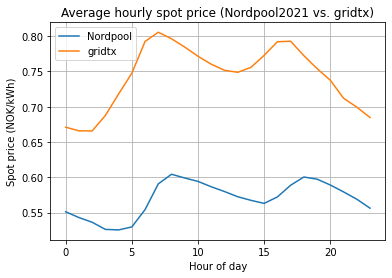

In [95]:
# Plot for one
df_oslo_month = df_oslo[df_oslo.index.month == 3]
df_oslo_week = df_oslo_month[df_oslo_month.index.isocalendar().week == 1]
df_oslo_day = df_oslo_month[df_oslo_month.index.day == 4]
df_oslo_day

# Plot df_oslo_day
# plt.plot(df_oslo_day["hour"], df_oslo_day["price"])


plt.clf()
# plot title
plt.title("Average hourly spot price (Nordpool2021 vs. gridtx)")
# x-axis label
plt.xlabel("Hour of day")
# y-axis label
plt.ylabel("Spot price (NOK/kWh)")

plt.plot(avg_dict_oslo_hour.keys(), avg_dict_oslo_hour.values(), label="Nordpool")
plt.plot(df_cons_avg_hour_dict.keys(), df_cons_avg_hour_dict.values(), label="gridtx")
# show labels
plt.legend()
# show grid
plt.grid(True)
